<a href="https://colab.research.google.com/github/mtavakoliangit/ena/blob/main/allC1_Functionalkeras_polyfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from keras.callbacks import History
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

In [ ]:
import pickle
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd 
data_df=pd.read_csv('gdrive/My Drive/CO2_Database/groupedC1_minusConstP.csv')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gas                          1661 non-null   object 
 1   Rock                         1661 non-null   object 
 2   TOC (%)                      1661 non-null   float64
 3   Moisture (%)                 1661 non-null   float64
 4   Temp (C)                     1661 non-null   float64
 5   Pres. (MPa)                  1661 non-null   float64
 6   C1 Excess Sorption (cm3/gr)  1661 non-null   float64
dtypes: float64(5), object(2)
memory usage: 91.0+ KB


In [ ]:
data_df.describe()

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr)
count,1661.000000,1661.000000,1661.000000,1661.000000,1661.000000
mean,15.649607,1.096797,56.230825,9.665183,1.493944
std,25.923400,1.895442,16.056862,7.080627,1.378896
min,0.090000,0.000000,30.000000,0.164000,0.001600
25%,2.364292,0.000000,38.000000,3.390000,0.502000
50%,5.150000,0.000000,61.000000,8.418500,1.147800
75%,7.700000,1.720000,65.000000,15.119500,2.050500
max,88.500000,7.340000,150.000000,27.861700,7.036200


In [ ]:
# Function to insert row in the dataframe
def Insert_row(row_number, df, row_value):
	# Starting value of upper half
	start_upper = 0

	# End value of upper half
	end_upper = row_number

	# Start value of lower half
	start_lower = row_number

	# End value of lower half
	end_lower = df.shape[0]

	# Create a list of upper_half index
	upper_half = [*range(start_upper, end_upper, 1)]

	# Create a list of lower_half index
	lower_half = [*range(start_lower, end_lower, 1)]

	# Increment the value of lower half by 1
	lower_half = [x.__add__(1) for x in lower_half]

	# Combine the two lists
	index_ = upper_half + lower_half

	# Update the index of the dataframe
	df.index = index_

	# Insert a row at the end
	df.loc[row_number] = row_value

	# Sort the index labels
	df = df.sort_index()

	# return the dataframe
	return df

#### Adding P=0, sorption=0 to the datasets, counting the number of datasets (experiments):

In [ ]:
i = 0
row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
data_df = Insert_row(i, data_df, row_value)

In [ ]:
P = []
sorp = []
polyfit_df = pd.DataFrame(columns=['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'a', 'b', 'c', 'd'])
# df_backup is a shadow of polyfit_df to be used for de-normalisation 
df_backup = pd.DataFrame(columns=['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'a', 'b', 'c', 'd'])

In [ ]:
while i < data_df.shape[0] - 1:
    i += 1
    if data_df['Pres. (MPa)'][i] > data_df['Pres. (MPa)'][i-1]:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
    else:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
        row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
        data_df = Insert_row(i, data_df, row_value)
        poly = np.polyfit(P, sorp, deg=3)
        polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'a': poly[0], 'b': poly[1], 'c': poly[2], 'd': poly[3]},ignore_index=True)
        df_backup = df_backup.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'a': poly[0], 'b': poly[1], 'c': poly[2], 'd': poly[3]},ignore_index=True)
        P = []
        sorp = []

#last experimental data set:
P.append(data_df['Pres. (MPa)'][data_df.shape[0]-1])
sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][data_df.shape[0]-1])
poly = np.polyfit(P, sorp, deg=3)
polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'a': poly[0], 'b': poly[1], 'c': poly[2], 'd': poly[3]},ignore_index=True)
df_backup = df_backup.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'a': poly[0], 'b': poly[1], 'c': poly[2], 'd': poly[3]},ignore_index=True)

In [ ]:
num_exp = polyfit_df.shape[0] #number of experimental datasets

In [ ]:
polyfit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gas           122 non-null    object 
 1   Rock          122 non-null    object 
 2   TOC (%)       122 non-null    float64
 3   Moisture (%)  122 non-null    float64
 4   Temp (C)      122 non-null    float64
 5   a             122 non-null    float64
 6   b             122 non-null    float64
 7   c             122 non-null    float64
 8   d             122 non-null    float64
dtypes: float64(7), object(2)
memory usage: 8.7+ KB


In [ ]:
polyfit_df.head()

,Gas,Rock,TOC (%),Moisture (%),Temp (C),a,b,c,d
0,CH4,Shale/Clay,0.44,0.66,50.0,0.000071,-0.004063,0.084773,0.006556
1,CH4,Shale/Clay,0.09,1.51,38.0,0.000034,-0.001648,0.029622,0.003540
2,CH4,Shale/Clay,3.25,1.47,38.0,-0.000004,-0.001721,0.056056,-0.010959
3,CH4,Shale/Clay,0.38,1.87,38.0,0.000087,-0.003489,0.070049,0.000219
4,CH4,Shale/Clay,0.75,0.59,38.0,-0.000037,-0.000369,0.033971,-0.007542


In [ ]:
df = polyfit_df

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)', 'a', 'b', 'c', 'd']
for col in cols:
  #scale = StandardScaler().fit(df[[col]])
  #df[[col]] = scale.transform(df[[col]])
  norm = MinMaxScaler().fit(df[[col]])
  df[[col]] = norm.transform(df[[col]])

In [ ]:
df.describe()

,TOC (%),Moisture (%),Temp (C),a,b,c,d
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.173204,0.196710,0.213183,0.174554,0.829492,0.214009,0.288495
std,0.295739,0.271314,0.142779,0.197608,0.209815,0.238653,0.156909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025724,0.000000,0.066667,0.089021,0.838393,0.059444,0.177186
50%,0.056283,0.000000,0.258333,0.099626,0.907237,0.131683,0.249852
75%,0.084662,0.408719,0.291667,0.144018,0.937307,0.243090,0.364751
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


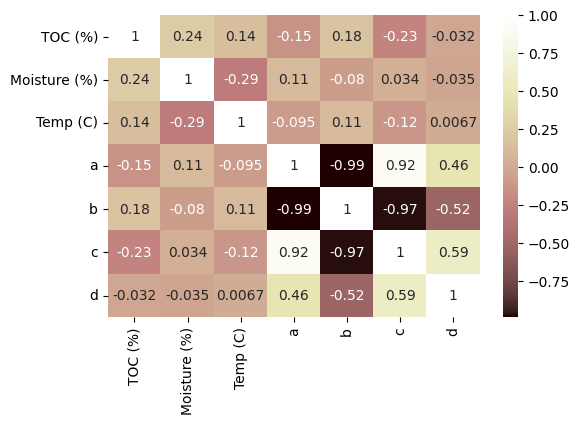

In [ ]:
sns.heatmap(df.corr(), cmap="pink", annot=True)

In [ ]:
df['Rock'].unique()

array(['Shale/Clay', 'Coal'], dtype=object)

### One-hot encoding for the Gas and Rock columns:

In [ ]:
gas_dic = {'CH4': 0, 'CO2': 1}
df.Gas = [gas_dic[item] for item in df.Gas]

In [ ]:
rock_dic = {'Shale/Clay': 0, 'Coal': 1}
df.Rock = [rock_dic[item] for item in df.Rock]

In [ ]:
x = df.drop(['a', 'b', 'c', 'd'],axis=1)
y = df[['a', 'b', 'c', 'd']]

### Because we have only C1 here, I am going to drop the Gas column:

In [ ]:
x = x.drop(['Gas'], axis=1)

In [ ]:
x.head()

,Rock,TOC (%),Moisture (%),Temp (C)
0,0,0.003959,0.089918,0.166667
1,0,0.000000,0.205722,0.066667
2,0,0.035743,0.200272,0.066667
3,0,0.003280,0.254768,0.066667
4,0,0.007465,0.080381,0.066667


In [ ]:
x['Rock'].unique()

array([0, 1])

In [ ]:
RAND_STAT = 200

In [ ]:
#Create train and test dataset with an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=RAND_STAT)
#Further divide training dataset into train and validation dataset with an 90:10 split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=RAND_STAT)
#Check the sizes of all newly created datasets
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (103, 4)
Shape of x_val: (12, 4)
Shape of x_test: (7, 4)
Shape of y_train: (103, 4)
Shape of y_val: (12, 4)
Shape of y_test: (7, 4)


In [ ]:
x_train=np.asarray(x_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
x_val=np.asarray(x_val).astype(np.float32)
y_val=np.asarray(y_val).astype(np.float32)

In [ ]:
history = History()
#Defining Functional model
input_layer = Input(shape=(4,))
Layer_1 = Dense(500,activation="relu")(input_layer)
Layer_2 = Dense(200,activation="relu")(Layer_1)
Layer_3 = Dense(40,activation="relu")(Layer_2)
Layer_4 = Dense(10,activation="tanh")(Layer_3)
output_layer = Dense(4,activation="tanh")(Layer_4)
model = Model(inputs=input_layer, outputs=output_layer)
#Configure the model
keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='Adam',loss="mean_squared_logarithmic_error",metrics=["mean_absolute_error"])
#Train the model
model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=50,batch_size=32,callbacks=[history])

Epoch 1/50
4/4 [==============================] - 2s 138ms/step - loss: 0.1244 - mean_absolute_error: 0.3860 - val_loss: 0.0879 - val_mean_absolute_error: 0.3684
Epoch 2/50
4/4 [==============================] - 0s 20ms/step - loss: 0.0860 - mean_absolute_error: 0.3818 - val_loss: 0.0567 - val_mean_absolute_error: 0.3901
Epoch 3/50
4/4 [==============================] - 0s 27ms/step - loss: 0.0604 - mean_absolute_error: 0.4018 - val_loss: 0.0464 - val_mean_absolute_error: 0.4061
Epoch 4/50
4/4 [==============================] - 0s 43ms/step - loss: 0.0508 - mean_absolute_error: 0.4117 - val_loss: 0.0392 - val_mean_absolute_error: 0.3896
Epoch 5/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0448 - mean_absolute_error: 0.3908 - val_loss: 0.0320 - val_mean_absolute_error: 0.3413
Epoch 6/50
4/4 [==============================] - 0s 18ms/step - loss: 0.0416 - mean_absolute_error: 0.3509 - val_loss: 0.0315 - val_mean_absolute_error: 0.3135
Epoch 7/50
4/4 [=================

In [ ]:
x_test=np.asarray(x_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [ ]:
result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

1/1 [==============================] - 0s 39ms/step - loss: 0.0550 - mean_absolute_error: 0.4092
Metric  loss : 0.05
Metric  mean_absolute_error : 0.41


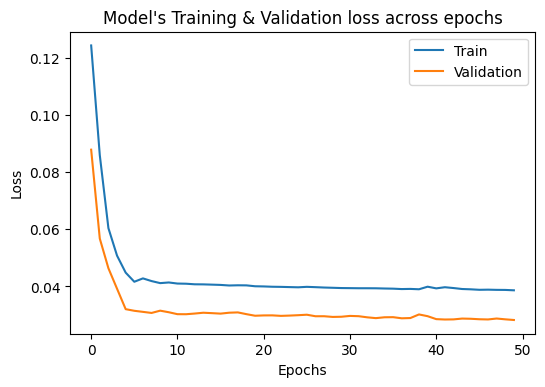

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [ ]:
def linear_model_results(axes_num, y_actual, y_prediction, title):
    linear_model = LinearRegression().fit(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    r_sq = linear_model.score(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    print('coefficient of determination:', r_sq)
    print('coef_:', linear_model.coef_)
    print('intercept:', linear_model.intercept_)
    
    axes[axes_num].plot( y_actual,  linear_model.coef_[0][0] * y_actual + linear_model.intercept_[0],
                linestyle='--', color = 'darkblue')  
    axes[axes_num].scatter( y_actual, y_prediction,
                            linewidths=2, edgecolor='black', color = 'lightblue') 
    axes[axes_num].set_xlabel('Actual')
    axes[axes_num].set_ylabel(title)

coefficient of determination: 0.04312283613880785
coef_: [[0.07542239]]
intercept: [-0.19384348]


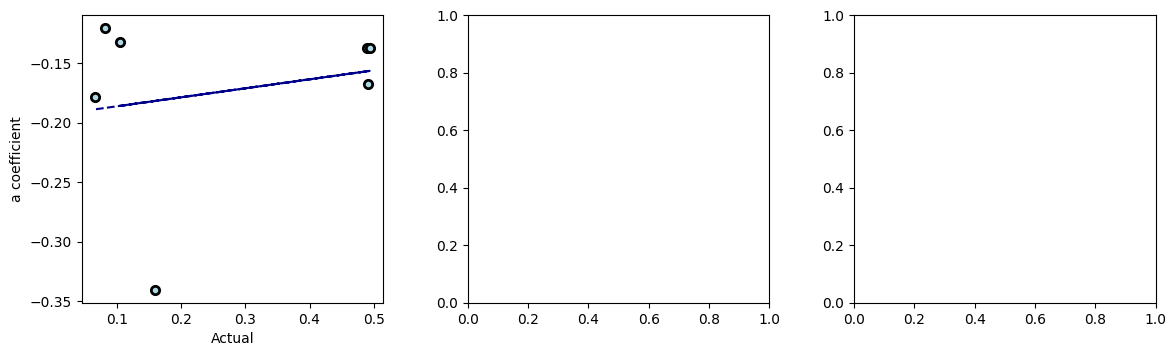

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,0], y_test_pred[:,0], 'a coefficient')

coefficient of determination: 0.012260269875063234
coef_: [[-0.03463084]]
intercept: [0.8420952]


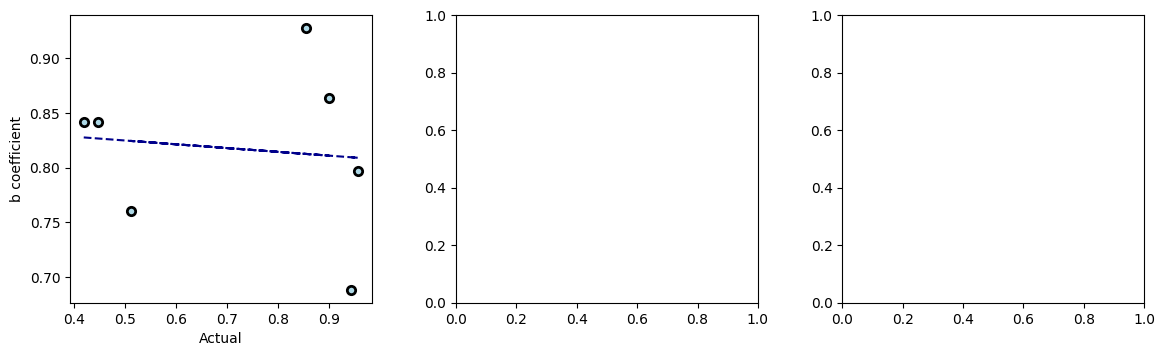

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,1], y_test_pred[:,1], 'b coefficient')

coefficient of determination: 0.07346596167204744
coef_: [[0.08259711]]
intercept: [0.1816833]


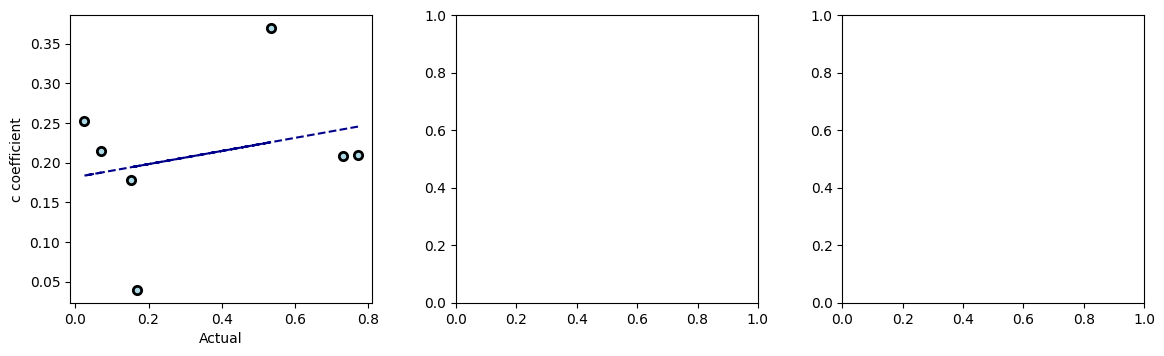

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,2], y_test_pred[:,2], 'c coefficient')

coefficient of determination: 0.2032893401922128
coef_: [[-0.20357089]]
intercept: [-0.3629722]


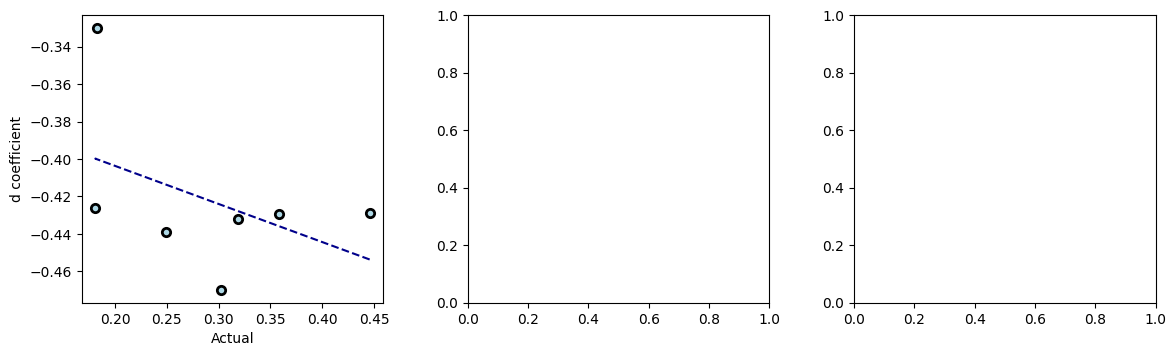

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,3], y_test_pred[:,3], 'd coefficient')

In [ ]:
pd.DataFrame(abs(y_test_pred - y_test)*100/y_test)

,0,1,2,3
0,128.060715,100.702881,72.840881,196.255646
1,127.823669,88.493958,71.416229,219.813675
2,227.378113,3.946606,16.933357,235.592117
3,134.162582,48.916111,30.895403,255.425476
4,314.470825,8.558509,76.059395,276.069885
5,250.101532,16.665215,1004.557129,335.475372
6,370.526245,26.986214,202.487076,281.232422


In [ ]:
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

In [ ]:
x_test.head()

,0,1,2,3
0,0.0,0.055735,0.000000,0.166667
1,0.0,0.055386,0.000000,0.170000
2,0.0,0.049881,0.000000,0.291667
3,0.0,0.057233,0.408719,0.333333
4,1.0,0.702522,0.000000,0.258333


In [ ]:
y_test.head()

,0,1,2,3
0,0.490301,0.419220,0.772356,0.445771
1,0.493730,0.446723,0.731196,0.358245
2,0.103735,0.899375,0.152742,0.318635
3,0.491407,0.510798,0.534330,0.302291
4,0.158698,0.854129,0.167194,0.249214


In [ ]:
x_test = x_test.rename(columns={0: 'Rock', 1: 'TOC (%)', 2: 'Moisture (%)', 3: 'Temp (C)'})
y_test = y_test.rename(columns={0: 'a', 1: 'b', 2: 'c', 3: 'd'})
y_test_pred = y_test_pred.rename(columns={0: 'a', 1: 'b', 2: 'c', 3: 'd'})

In [ ]:
rock_dic = {0: 'Shale/Clay', 1: 'Coal'}
x_test.Rock = [rock_dic[item] for item in x_test.Rock]

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  x_test[[col]] = norm.inverse_transform(x_test[[col]])

In [ ]:
cols = ['a', 'b', 'c', 'd']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  y_test[[col]] = norm.inverse_transform(y_test[[col]])
  y_test_pred[[col]] = norm.inverse_transform(y_test_pred[[col]])

In [ ]:
x_test

,Rock,TOC (%),Moisture (%),Temp (C)
0,Shale/Clay,5.017512,0.00,50.000004
1,Shale/Clay,4.986634,0.00,50.400002
2,Shale/Clay,4.500000,0.00,64.999992
3,Shale/Clay,5.150000,3.00,70.000008
4,Coal,62.200001,0.00,61.000000
5,Shale/Clay,2.340000,1.72,67.000000
6,Shale/Clay,1.640000,4.37,30.000000


In [ ]:
y_test

,a,b,c,d
0,0.006266,-0.175446,1.691596,0.202967
1,0.006318,-0.166586,1.601216,0.138973
2,0.000400,-0.020768,0.331034,0.110013
3,0.006283,-0.145945,1.168933,0.098063
4,0.001234,-0.035344,0.362767,0.059257
5,0.000048,-0.002494,0.045912,0.009437
6,-0.000172,-0.006712,0.151529,0.010260


In [ ]:
y_test_pred

,a,b,c,d
0,-0.003261,-0.039449,0.456246,-0.436667
1,-0.003258,-0.039236,0.454573,-0.436775
2,-0.003179,-0.032202,0.387828,-0.438835
3,-0.003721,-0.065454,0.806439,-0.466466
4,-0.006338,-0.011795,0.083531,-0.443768
5,-0.003008,-0.053822,0.550939,-0.434695
6,-0.003884,-0.088691,0.467188,-0.364375


### We are now going to test our model and predict using real experimental data:

In [ ]:
# It reads from original file again to NOT include the imposed (0,0) points.
data_df=pd.read_csv('gdrive/My Drive/CO2_Database/groupedC1_minusConstP.csv')

In [ ]:
(data_df.shape[0], df.shape[0])

(1661, 122)

In [ ]:
#for denormalisation purpose
norm_a = MinMaxScaler().fit(df_backup[['a']])
norm_b = MinMaxScaler().fit(df_backup[['b']])
norm_c = MinMaxScaler().fit(df_backup[['c']])
norm_d = MinMaxScaler().fit(df_backup[['d']])

In [ ]:
i = 0
P = []
sorp_exp = []
sorp_pred = []
num_exp = 1
cols = ['a', 'b', 'c', 'd']
Result = []

P.append(data_df['Pres. (MPa)'][i])
sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i])

while i < data_df.shape[0] - 1:
    i += 1
    if data_df['Pres. (MPa)'][i] > data_df['Pres. (MPa)'][i-1]:
        #experimental data:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
    else:
        #experimental data (cont'd):
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
        #model prediction:
        poly_coef = df.iloc[[num_exp-1]]
        feed = poly_coef[['Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)']]
        result = model.predict(feed)

        result[0][0] = norm_a.inverse_transform(result[0][0].reshape(1, -1))
        result[0][1] = norm_b.inverse_transform(result[0][1].reshape(1, -1))
        result[0][2] = norm_c.inverse_transform(result[0][2].reshape(1, -1))
        result[0][3] = norm_d.inverse_transform(result[0][3].reshape(1, -1))
        Result.append(result)
        
        for j in range(0, len(P)):
            sorp_pred.append(result[0][0]*P[j]**3 + result[0][1]*P[j]**2 + result[0][2]*P[j] + result[0][3])
            #print(sorp_exp[j], sorp_pred[j])
            #print(100*(sorp_pred[j] - sorp_exp[j])/sorp_exp[j])
        #comparison between experimental and calculated:
        #correlation_matrix = np.corrcoef(x_values, y_values)
        #correlation_xy = correlation_matrix[0,1]
        #r_squared = correlation_xy**2

        P = []
        sorp_exp = []
        sorp_pred = []
        num_exp += 1

In [ ]:
#last experimental data set:
P.append(data_df['Pres. (MPa)'][data_df.shape[0]-1])
sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][data_df.shape[0]-1])
poly_coef = df.iloc[[num_exp-1]]
feed = poly_coef[['Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)']]
result = model.predict(feed)
result[0][0] = norm_a.inverse_transform(result[0][0].reshape(1, -1))
result[0][1] = norm_b.inverse_transform(result[0][1].reshape(1, -1))
result[0][2] = norm_c.inverse_transform(result[0][2].reshape(1, -1))
result[0][3] = norm_d.inverse_transform(result[0][3].reshape(1, -1))
Result.append(result)
num_exp += 1

In [ ]:
df.shape

(122, 9)

In [ ]:
len(Result)

122